**Model** 
- **Backbone**: ViT-small or ConvNeXt-Tiny (pretrained on ImageNet)  
- **Output**: 512-dim normalized embedding  
- **Loss**: InfoNCE / triplet loss (contrastive)  
- **Input**: random 256×256 crops (2 views per image)  
- **Training**: self-supervised SimCLR-style

**Inference** 
- Compute one embedding per page in the dataset.
- Store all embeddings in a FAISS index.
- Given a new page screenshot → compute embedding → nearest neighbor → predicted page.

## **Imports**

In [1]:
import os, torch, numpy as np, faiss
from PIL import Image
from tqdm import tqdm
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import timm

c:\SIHAB\User_Sihab\Workstation\Pytorch_Env\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Data & Augmentations**

In [2]:
class SimCLRDataset(Dataset):
    def __init__(self, root_dir, size=256):
        self.root_dir = root_dir
        self.samples = []
        for subdir in sorted(os.listdir(root_dir)):
            path = os.path.join(root_dir, subdir)
            if not os.path.isdir(path):
                continue
            files = [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            for f in files:  # <--- include all images, not just one
                self.samples.append(os.path.join(path, f))
                
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(size=size, scale=(0.6, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
            transforms.RandomApply([transforms.GaussianBlur(5)], p=0.3),
            transforms.RandomGrayscale(p=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    
    def __getitem__(self, idx):
        img = Image.open(self.samples[idx]).convert('RGB')
        return self.transform(img), self.transform(img)
    
    def __len__(self):
        return len(self.samples)



## **Model Definition**

In [3]:
class ProjectionHead(nn.Module):
    def __init__(self, in_dim, hidden_dim=2048, out_dim=512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, out_dim),
        )
    def forward(self, x): return self.net(x)

class EncoderWithProjection(nn.Module):
    def __init__(self, backbone='convnext_tiny', proj_dim=512):
        super().__init__()
        self.backbone = timm.create_model(backbone, pretrained=True, num_classes=0, global_pool='avg')
        self.projection = ProjectionHead(self.backbone.num_features, self.backbone.num_features*4, proj_dim)
    def forward(self, x):
        z = self.projection(self.backbone(x))
        return nn.functional.normalize(z, dim=1)


## **InfoNCE Loss Function**

In [4]:
def nt_xent_loss(z1, z2, temp=0.1):
    z = torch.cat([z1, z2], dim=0)
    sim = torch.matmul(z, z.T) / temp
    N = z.shape[0]
    mask = ~torch.eye(N, dtype=bool, device=z.device)
    sim = sim.masked_select(mask).view(N, N-1)
    pos = torch.sum(z1 * z2, dim=1) / temp
    pos = torch.cat([pos, pos], dim=0)
    denom = torch.sum(torch.exp(sim), dim=1)
    return torch.mean(-torch.log(torch.exp(pos) / denom))


## **Training Loop**

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = EncoderWithProjection('convnext_tiny').to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
dataset = SimCLRDataset(r"C:\\SIHAB\\User_Sihab\\Workstation\\Datasets\\TIN GOYENDA VOL28 - Copy\\train")
loader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

In [6]:
len(loader)


201

In [7]:
for epoch in range(10):
    model.train()
    total_loss = 0
    for x1, x2 in tqdm(loader):
        x1, x2 = x1.to(device), x2.to(device)
        z1, z2 = model(x1), model(x2)
        loss = nt_xent_loss(z1, z2)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, loss = {total_loss/len(loader):.4f}")
torch.save(model.state_dict(), "simclr_model.pth")

100%|██████████| 201/201 [03:59<00:00,  1.19s/it]


Epoch 1, loss = 0.2156


100%|██████████| 201/201 [04:11<00:00,  1.25s/it]


Epoch 2, loss = 0.0607


100%|██████████| 201/201 [04:15<00:00,  1.27s/it]


Epoch 3, loss = 0.0533


100%|██████████| 201/201 [04:15<00:00,  1.27s/it]


Epoch 4, loss = 0.0390


100%|██████████| 201/201 [04:15<00:00,  1.27s/it]


Epoch 5, loss = 0.0376


100%|██████████| 201/201 [04:15<00:00,  1.27s/it]


Epoch 6, loss = 0.0319


100%|██████████| 201/201 [04:15<00:00,  1.27s/it]


Epoch 7, loss = 0.0321


100%|██████████| 201/201 [04:16<00:00,  1.27s/it]


Epoch 8, loss = 0.0285


100%|██████████| 201/201 [04:15<00:00,  1.27s/it]


Epoch 9, loss = 0.0320


100%|██████████| 201/201 [04:16<00:00,  1.27s/it]

Epoch 10, loss = 0.0294


## **Embedding Extraction + FAISS Index**

In [8]:
embed_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

def compute_embeddings(model, root_dir="C:\\SIHAB\\User_Sihab\\Workstation\\Datasets\\TIN GOYENDA VOL28 - Copy\\train"):
    model.eval()
    vecs, paths = [], []
    with torch.no_grad():
        for cls in sorted(os.listdir(root_dir)):
            path = os.path.join(root_dir, cls)
            if not os.path.isdir(path): continue
            img_file = [f for f in os.listdir(path) if f.endswith(('.jpg','.png'))][0]
            img = Image.open(os.path.join(path, img_file)).convert('RGB')
            x = embed_transform(img).unsqueeze(0).to(device)
            z = model(x).cpu().numpy().astype('float32')
            vecs.append(z)
            paths.append(os.path.join(path, img_file))
    vecs = np.vstack(vecs)
    faiss.normalize_L2(vecs)
    return vecs, paths

vecs, paths = compute_embeddings(model)
index = faiss.IndexFlatIP(vecs.shape[1])
index.add(vecs)
np.save('paths.npy', np.array(paths))
faiss.write_index(index, 'pages.index')


## **Query Phase**

In [9]:
import matplotlib.pyplot as plt

def query_image(img_path, model, index, paths, topk=5):
    model.eval()
    img = Image.open(img_path).convert('RGB')
    x = embed_transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        q = model(x).cpu().numpy().astype('float32')
    faiss.normalize_L2(q)

    # Search top-k nearest neighbors
    D, I = index.search(q, topk)
    scores = D[0]
    indices = I[0]

    # --- Plot query and results side by side ---
    plt.figure(figsize=(15, 3))
    plt.subplot(1, topk + 1, 1)
    plt.imshow(img)
    plt.title("Query", fontsize=14)
    plt.axis("off")

    for i, (score, idx) in enumerate(zip(scores, indices)):
        result_img = Image.open(paths[idx]).convert("RGB")
        plt.subplot(1, topk + 1, i + 2)
        plt.imshow(result_img)
        plt.title(f"Top {i+1}\nscore={score:.3f}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

    # Optionally print file paths for reference
    print("\nNearest pages:")
    for i, (score, idx) in enumerate(zip(scores, indices)):
        print(f"{i+1}. {paths[idx]} (similarity: {score:.3f})")


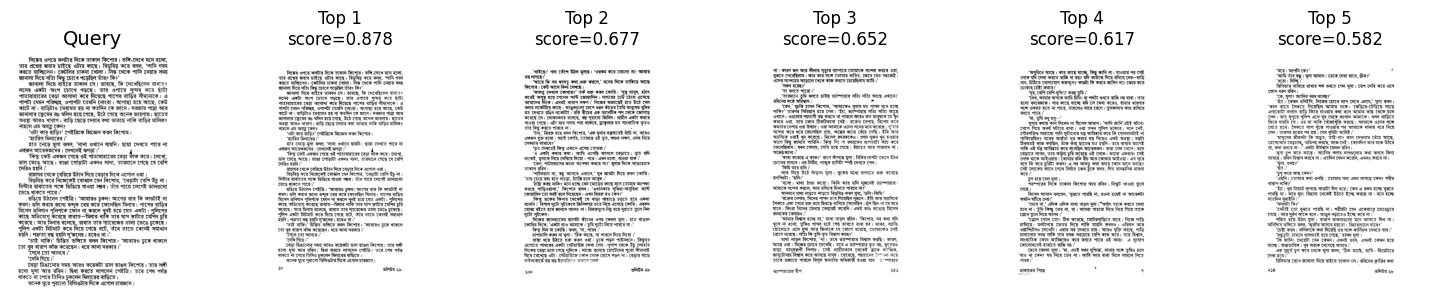


Nearest pages:
1. C:\SIHAB\User_Sihab\Workstation\Datasets\TIN GOYENDA VOL28 - Copy\train\class_13\page_13.jpg (similarity: 0.878)
2. C:\SIHAB\User_Sihab\Workstation\Datasets\TIN GOYENDA VOL28 - Copy\train\class_111\page_111.jpg (similarity: 0.677)
3. C:\SIHAB\User_Sihab\Workstation\Datasets\TIN GOYENDA VOL28 - Copy\train\class_254\page_254.jpg (similarity: 0.652)
4. C:\SIHAB\User_Sihab\Workstation\Datasets\TIN GOYENDA VOL28 - Copy\train\class_10\page_10.jpg (similarity: 0.617)
5. C:\SIHAB\User_Sihab\Workstation\Datasets\TIN GOYENDA VOL28 - Copy\train\class_217\page_217.jpg (similarity: 0.582)


In [24]:
index = faiss.read_index('pages.index')
paths = np.load('paths.npy', allow_pickle=True)
query_image(r'C:\SIHAB\User_Sihab\Workstation\Pytorch_Env\page_13.png', model, index, paths, topk=5)
